# Data Ingestion

In [1]:
import torch
import numpy as np
import random

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [2]:
import scipy.io as sio

kuka_data = sio.loadmat('/kaggle/input/industrial-manipulator-forward-dynamics-data/KukaDirectDynamics.mat')

In [3]:
print(kuka_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'kukatraj1', 'kukatraj10', 'kukatraj2', 'kukatraj3', 'kukatraj4', 'kukatraj5', 'kukatraj6', 'kukatraj7', 'kukatraj8', 'kukatraj9'])


# Preprocessing

In [ ]:
trajectories = {}
# Filter out non-trajectory keys and prepare data for training
for key, value in kuka_data.items():
    if key.startswith('kukatraj') and isinstance(value, np.ndarray):
        trajectories[key] = value

In [ ]:
best_params = {'n_reservoir': 1100,'spectral_radius': 1.15,'sparsity': 0.4,'leak_rate': 0.4,'ghl_eta': 7.703794486260076e-05,'ghl_decay_steps': 1500}

# In-depth Evaluation
---

In [ ]:
import torch
import sys
import utils
sys.path.append('models')

import pc_esn_model

trajectory_keys = sorted(list(trajectories.keys()))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("--- PC-ESN++ Evaluation Setup ---")
print(f"Using device: {device}")
if torch.cuda.is_available(): print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Trajectories: {len(trajectory_keys)}")
print("-" * 33)

fold_results = []

--- PC-ESN++ Evaluation Setup ---
Using device: cuda
GPU: Tesla P100-PCIE-16GB
Trajectories: 10
---------------------------------


In [ ]:
import time
from sklearn.preprocessing import StandardScaler

traj = 4

overall_start_time = time.time()

for i, test_key in enumerate(trajectory_keys[:4]):
    fold_start_time = time.time()
    print(f"\n--- Fold {i+1}/{len(trajectory_keys)} ---")
    print(f"Testing on: {test_key}")

    # 1. Data Preparation for the current fold
    train_keys = [k for k in trajectory_keys if k != test_key]
    train_traj = np.concatenate([trajectories[key] for key in train_keys], axis=0)
    test_traj = trajectories[test_key]

    X_train, y_train = train_traj[:, :21], train_traj[:, 21:]
    X_test, y_test = test_traj[:, :21], test_traj[:, 21:] # y_test is kept unscaled

    # 2. Fit scalers ONLY on the current fold's training data
    x_scaler_fold = StandardScaler()
    y_scaler_fold = StandardScaler()
    
    X_train_scaled = x_scaler_fold.fit_transform(X_train)
    y_train_scaled = y_scaler_fold.fit_transform(y_train)
    
    # Apply the same scaling to the test data for this fold
    X_test_scaled = x_scaler_fold.transform(X_test)

    # 3. Convert to Tensors
    X_train_t = torch.from_numpy(X_train_scaled).float().to(device)
    y_train_t = torch.from_numpy(y_train_scaled).float().to(device)
    X_test_t = torch.from_numpy(X_test_scaled).float().to(device)

    # 4. Model Training (on scaled data)
    model = pc_esn_model.PC_ESN(n_inputs=21, n_outputs=14,
                   n_reservoir=best_params['n_reservoir'],
                   spectral_radius=best_params['spectral_radius'],
                   sparsity=best_params['sparsity'],
                   leak_rate=best_params['leak_rate'],
                   ghl_eta=best_params['ghl_eta'],
                   ghl_decay_steps=best_params['ghl_decay_steps'],
                   device=device)

    model.train(X_train_t, y_train_t)
    training_time = time.time() - fold_start_time

    # 5. Evaluation (predictions are in scaled format)
    y_pred_step_scaled = pc_esn_model.predict_step_by_step(X_test_t)
    y_pred_full_scaled = pc_esn_model.predict_full_trajectory(X_test_t)

    # 6. Inverse transform predictions to original scale for metric calculation
    y_pred_step = y_scaler_fold.inverse_transform(y_pred_step_scaled)
    y_pred_full = y_scaler_fold.inverse_transform(y_pred_full_scaled)

    # 7. Calculate Metrics (on original scale data)
    nmse_step = utils.nMSE(y_test, y_pred_step)
    nmse_full = utils.nMSE(y_test, y_pred_full)
    euclid_err_step = utils.euclidean_error(y_test, y_pred_step)
    euclid_err_op_space_full = utils.calculate_op_space_error(y_test, y_pred_full)
    print(f"Step-by-Step Pos nMSE       | {np.mean(nmse_step[:7]):.4f}")
    print(f"Full Traj Pos nMSE          | {np.mean(nmse_full[:7]):.4f}")

    current_fold_results = {
        'fold': i + 1, 'training_time': training_time,
        'sbs_pos_nmse': np.mean(nmse_step[:7]), 'sbs_vel_nmse': np.mean(nmse_step[7:]),
        'full_pos_nmse': np.mean(nmse_full[:7]), 'full_vel_nmse': np.mean(nmse_full[7:]),
        'sbs_euclid_err': np.mean(euclid_err_step),
        'full_op_space_error': np.mean(euclid_err_op_space_full)
    }

    # Horizon Analysis (on original scale data)
    horizons = sorted(list(set([100, 200, 500, 1000, 1500, y_pred_full.shape[0]-1])))
    for h in horizons:

        error_h = np.mean((y_test[:h] - y_pred_full[:h])**2, axis=0)
        variance_full = np.var(y_test, axis=0)
        variance_full[variance_full == 0] = 1 # Avoid division by zero
        nmse_h = error_h / variance_full

        euclid_h = utils.euclidean_error(y_test[:h], y_pred_full[:h])
        current_fold_results[f'full_pos_nmse_h{h}'] = np.mean(nmse_h[:7])
        current_fold_results[f'full_euclid_err_h{h}'] = np.mean(euclid_h)

    fold_results.append(current_fold_results)
    traj -= 1
    print(f"Time to complete training: {(traj * (time.time()-fold_start_time))/60:.2f} minutes")

last_fold_preds = {'true': y_test, 'step': y_pred_step, 'full': y_pred_full}


--- Fold 1/10 ---
Testing on: kukatraj1
Step-by-Step Pos nMSE       | 0.2018
Full Traj Pos nMSE          | 1.2314
Time to complete training: 8.50 minutes

--- Fold 2/10 ---
Testing on: kukatraj10
Step-by-Step Pos nMSE       | 0.0292
Full Traj Pos nMSE          | 0.6991
Time to complete training: 5.61 minutes

--- Fold 3/10 ---
Testing on: kukatraj2
Step-by-Step Pos nMSE       | 0.0830
Full Traj Pos nMSE          | 2.2195
Time to complete training: 2.82 minutes

--- Fold 4/10 ---
Testing on: kukatraj3
Step-by-Step Pos nMSE       | 0.0593
Full Traj Pos nMSE          | 3.1595
Time to complete training: 0.00 minutes


In [26]:
import pandas as pd

# Aggregate and Display Final Results
print("\n\n--- Cross-Validation Complete ---")
print(f"Total execution time: {(time.time() - overall_start_time) / 60:.2f} minutes")

results_df = pd.DataFrame(fold_results)
mean_results = results_df.mean()
std_results = results_df.std()

print("\n--- PC-ESN++ Final Averaged Results (Mean ± Std Dev) ---")
print("Metric                      | Mean Value ± Std Deviation")
print("-" * 55)
print(f"Training Time (s)           | {mean_results['training_time']:.2f} ± {std_results['training_time']:.2f}")
print(f"Step-by-Step Pos nMSE       | {mean_results['sbs_pos_nmse']:.4f} ± {std_results['sbs_pos_nmse']:.4f}")
print(f"Step-by-Step Vel nMSE       | {mean_results['sbs_vel_nmse']:.4f} ± {std_results['sbs_vel_nmse']:.4f}")
print(f"Step-by-Step Euclid Err (m) | {mean_results['sbs_euclid_err']:.4f} ± {std_results['sbs_euclid_err']:.4f}")
print(f"Full Traj Pos nMSE          | {mean_results['full_pos_nmse']:.4f} ± {std_results['full_pos_nmse']:.4f}")
print(f"Full Traj Vel nMSE          | {mean_results['full_vel_nmse']:.4f} ± {std_results['full_vel_nmse']:.4f}")
print(f"Full Traj Euclid Err (m) | {mean_results['full_op_space_error']:.4f} ± {std_results['full_op_space_error']:.4f}")

print("-" * 55)

print("\n--- Error Accumulation Over Prediction Horizon ---")
print("Horizon | Position nMSE       | Op. Space Euclid Err (m)")
print("--------|---------------------|--------------------------")
for h in horizons:
    h_col_pos, h_col_euc = f'full_pos_nmse_h{h}', f'full_euclid_err_h{h}'
    if h_col_pos in mean_results:
        print(f"{h:<8}| {mean_results[h_col_pos]:.4f} ± {std_results[h_col_pos]:.4f}      | {mean_results[h_col_euc]:.4f} ± {std_results[h_col_euc]:.4f}")
print("-" * 55)



--- Cross-Validation Complete ---
Total execution time: 11.38 minutes

--- PC-ESN++ Final Averaged Results (Mean ± Std Dev) ---
Metric                      | Mean Value ± Std Deviation
-------------------------------------------------------
Training Time (s)           | 148.64 ± 17.24
Step-by-Step Pos nMSE       | 0.4021 ± 0.7010
Step-by-Step Vel nMSE       | 12198.8592 ± 21177.6399
Step-by-Step Euclid Err (m) | 0.0639 ± 0.0573
Full Traj Pos nMSE          | 3.1970 ± 2.1226
Full Traj Vel nMSE          | 11568.7085 ± 16581.5562
Full Traj Euclid Err (m) | 0.2023 ± 0.0767
-------------------------------------------------------

--- Error Accumulation Over Prediction Horizon ---
Horizon | Position nMSE       | Op. Space Euclid Err (m)
--------|---------------------|--------------------------
100     | 0.6569 ± 1.1624      | 0.0881 ± 0.0805
200     | 0.9341 ± 1.5986      | 0.1084 ± 0.0805
500     | 1.7114 ± 1.8114      | 0.1500 ± 0.0514
1000    | 3.1332 ± 2.3250      | 0.2059 ± 0.0807
1500

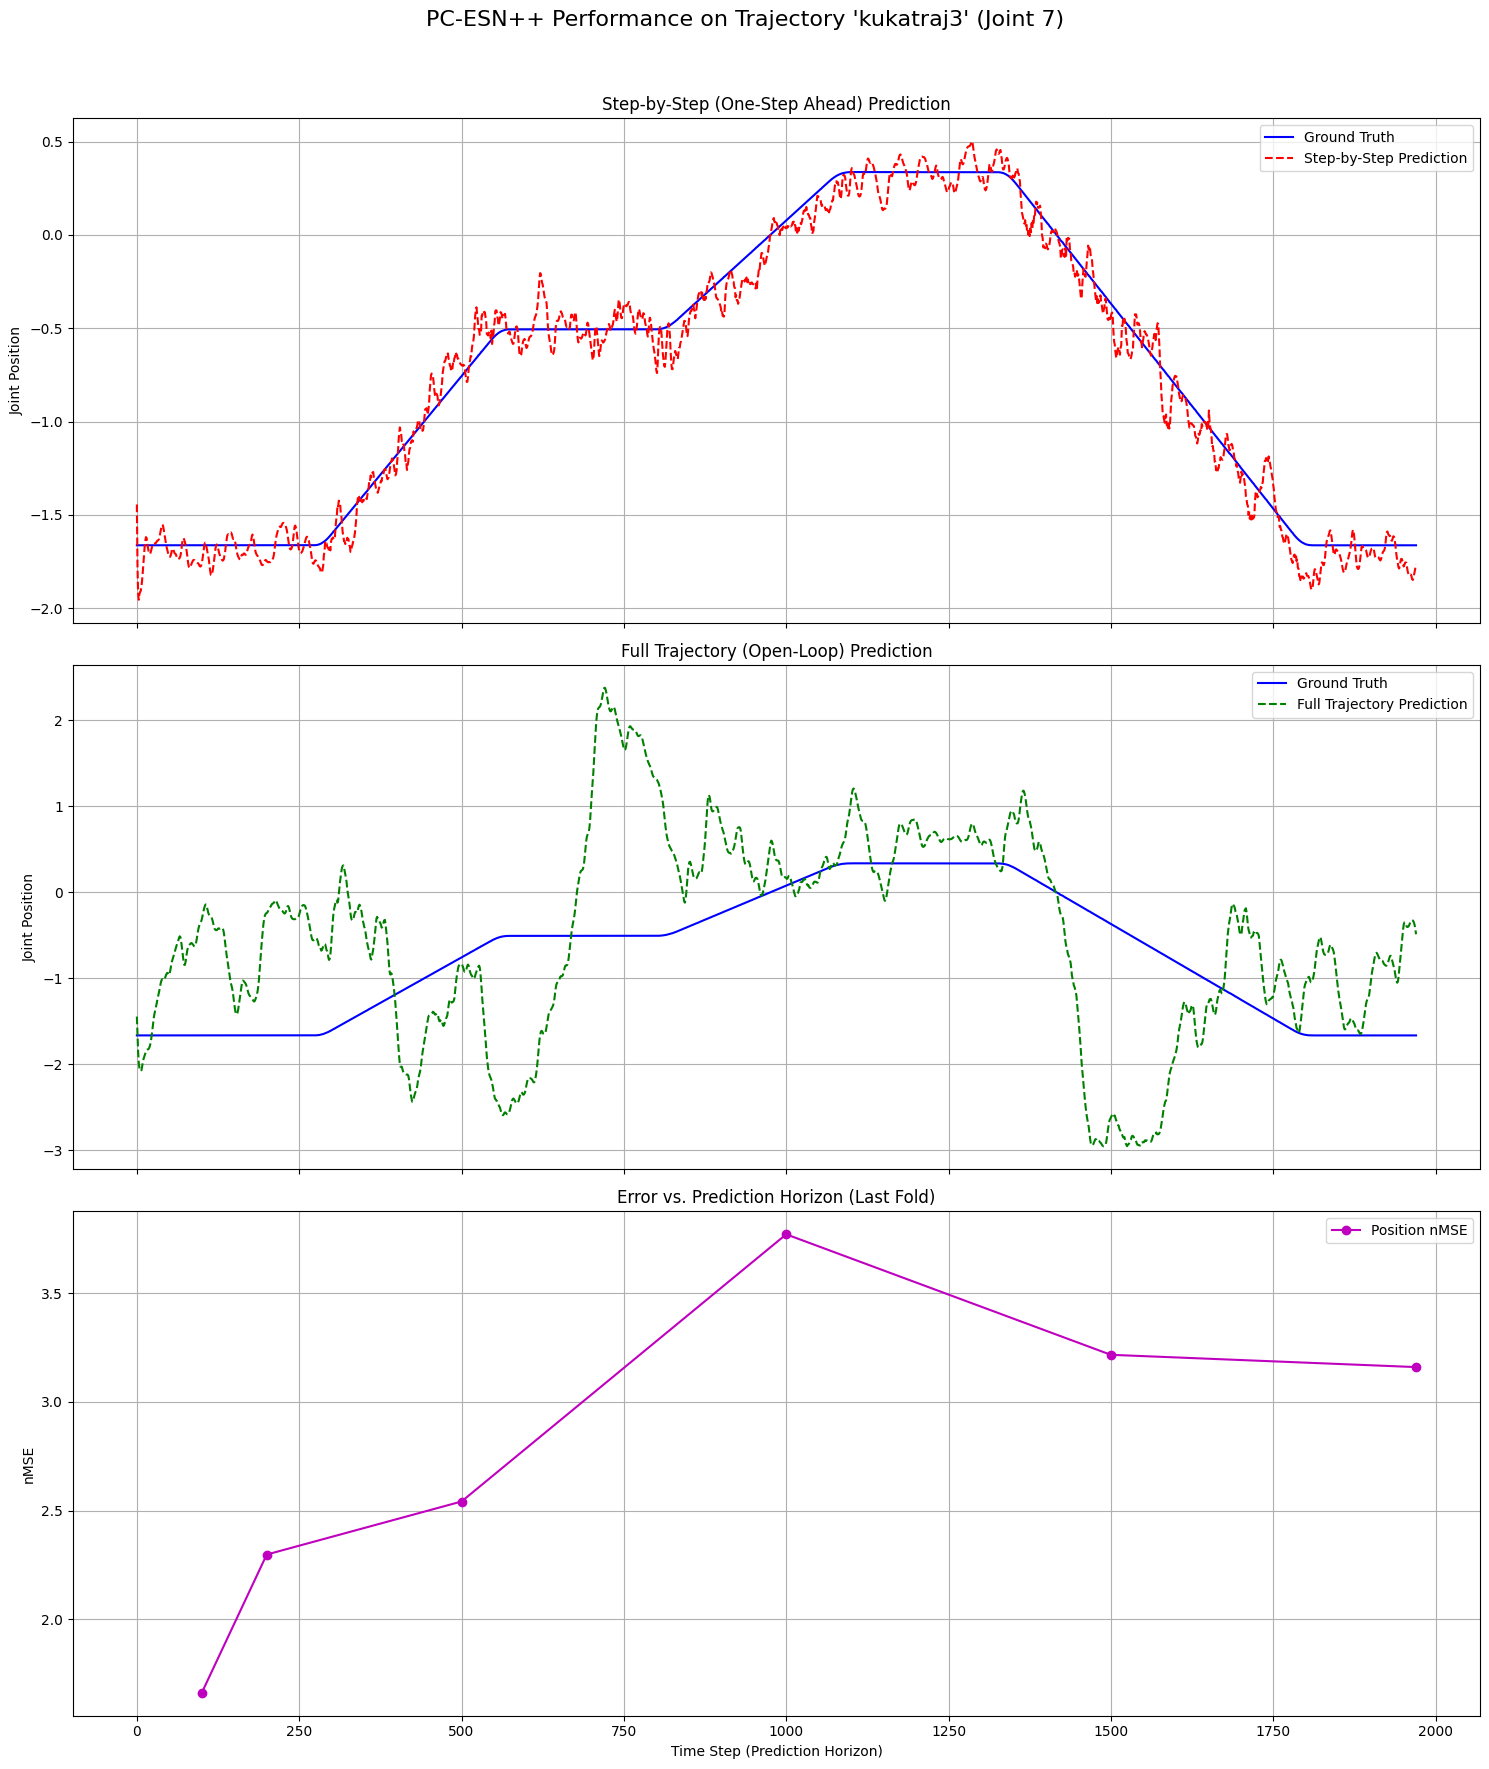

In [27]:
import matplotlib.pyplot as plt

# Visualization (from last fold)
joint_to_plot = 6
y_true_plot = last_fold_preds['true'][:, joint_to_plot]
y_pred_step_plot = last_fold_preds['step'][:, joint_to_plot]
y_pred_full_plot = last_fold_preds['full'][:, joint_to_plot]

fig, axs = plt.subplots(3, 1, figsize=(15, 18), sharex=True)
fig.suptitle(f"PC-ESN++ Performance on Trajectory '{test_key}' (Joint {joint_to_plot+1})", fontsize=16)

axs[0].plot(y_true_plot, 'b-', label='Ground Truth')
axs[0].plot(y_pred_step_plot, 'r--', label='Step-by-Step Prediction')
axs[0].set_title('Step-by-Step (One-Step Ahead) Prediction')
axs[0].set_ylabel('Joint Position'); axs[0].legend(); axs[0].grid(True)

axs[1].plot(y_true_plot, 'b-', label='Ground Truth')
axs[1].plot(y_pred_full_plot, 'g--', label='Full Trajectory Prediction')
axs[1].set_title('Full Trajectory (Open-Loop) Prediction')
axs[1].set_ylabel('Joint Position'); axs[1].legend(); axs[1].grid(True)

horizon_vals = [h for h in horizons if f'full_pos_nmse_h{h}' in results_df.columns]
horizon_errors_pos = [results_df.iloc[-1][f'full_pos_nmse_h{h}'] for h in horizon_vals]
axs[2].plot(horizon_vals, horizon_errors_pos, 'm-o', label='Position nMSE')
axs[2].set_title('Error vs. Prediction Horizon (Last Fold)')
axs[2].set_xlabel('Time Step (Prediction Horizon)'); axs[2].set_ylabel('nMSE'); axs[2].legend(); axs[2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [30]:
from scipy import stats

# --- Statistical Significance Test ---
print("\n--- Example of Statistical Significance Test ---")
baseline_results = {'full_pos_nmse': results_df['full_pos_nmse'] * (1.5 + np.random.rand(9) * 0.5)}
baseline_df = pd.DataFrame(baseline_results)
t_stat, p_value = stats.ttest_rel(results_df['full_pos_nmse'], baseline_df['full_pos_nmse'])
print("Paired t-test between PC-ESN++ and Baseline (Full Trajectory nMSE):")
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
if p_value < 0.05: print("The difference is statistically significant (p < 0.05).")
else: print("The difference is not statistically significant.")


--- Example of Statistical Significance Test ---
Paired t-test between PC-ESN++ and Baseline (Full Trajectory nMSE):
T-statistic: -4.9176, P-value: 0.0012
The difference is statistically significant (p < 0.05).


(-0.5795222416520118,
 2.4416279390454294,
 -0.6611937284469604,
 0.6196731328964233)

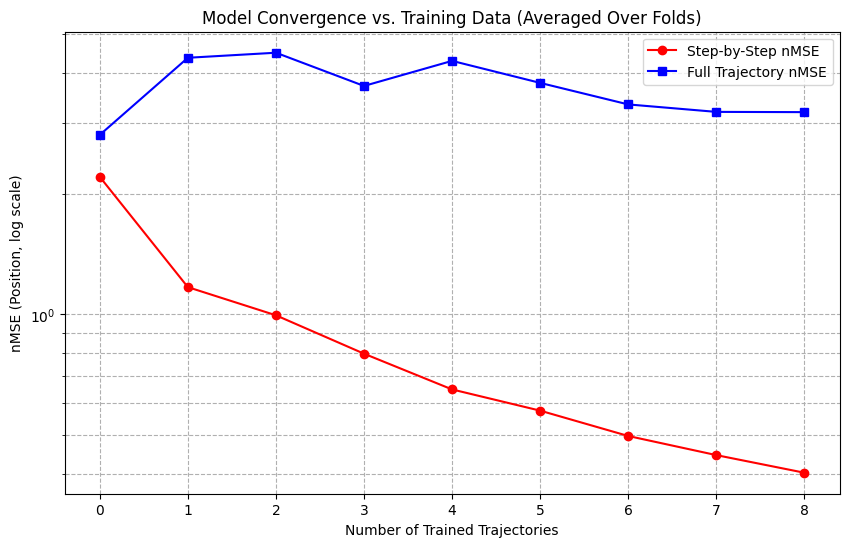

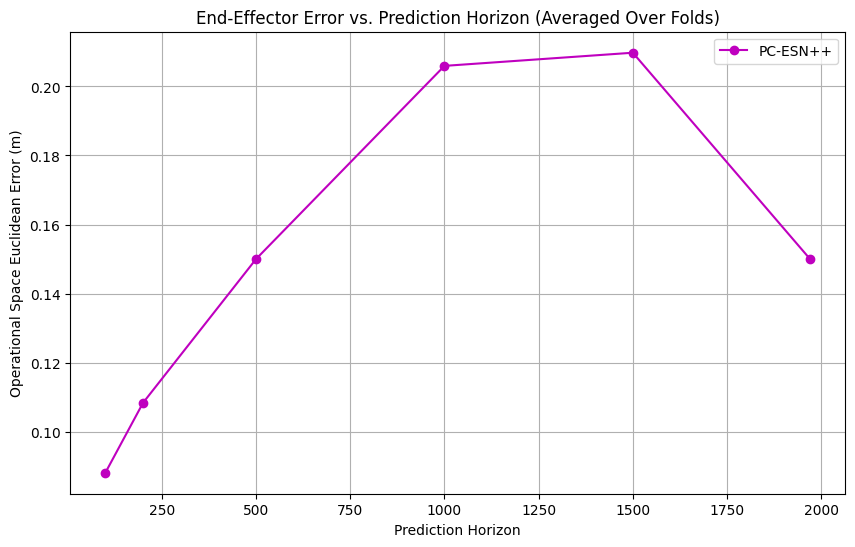

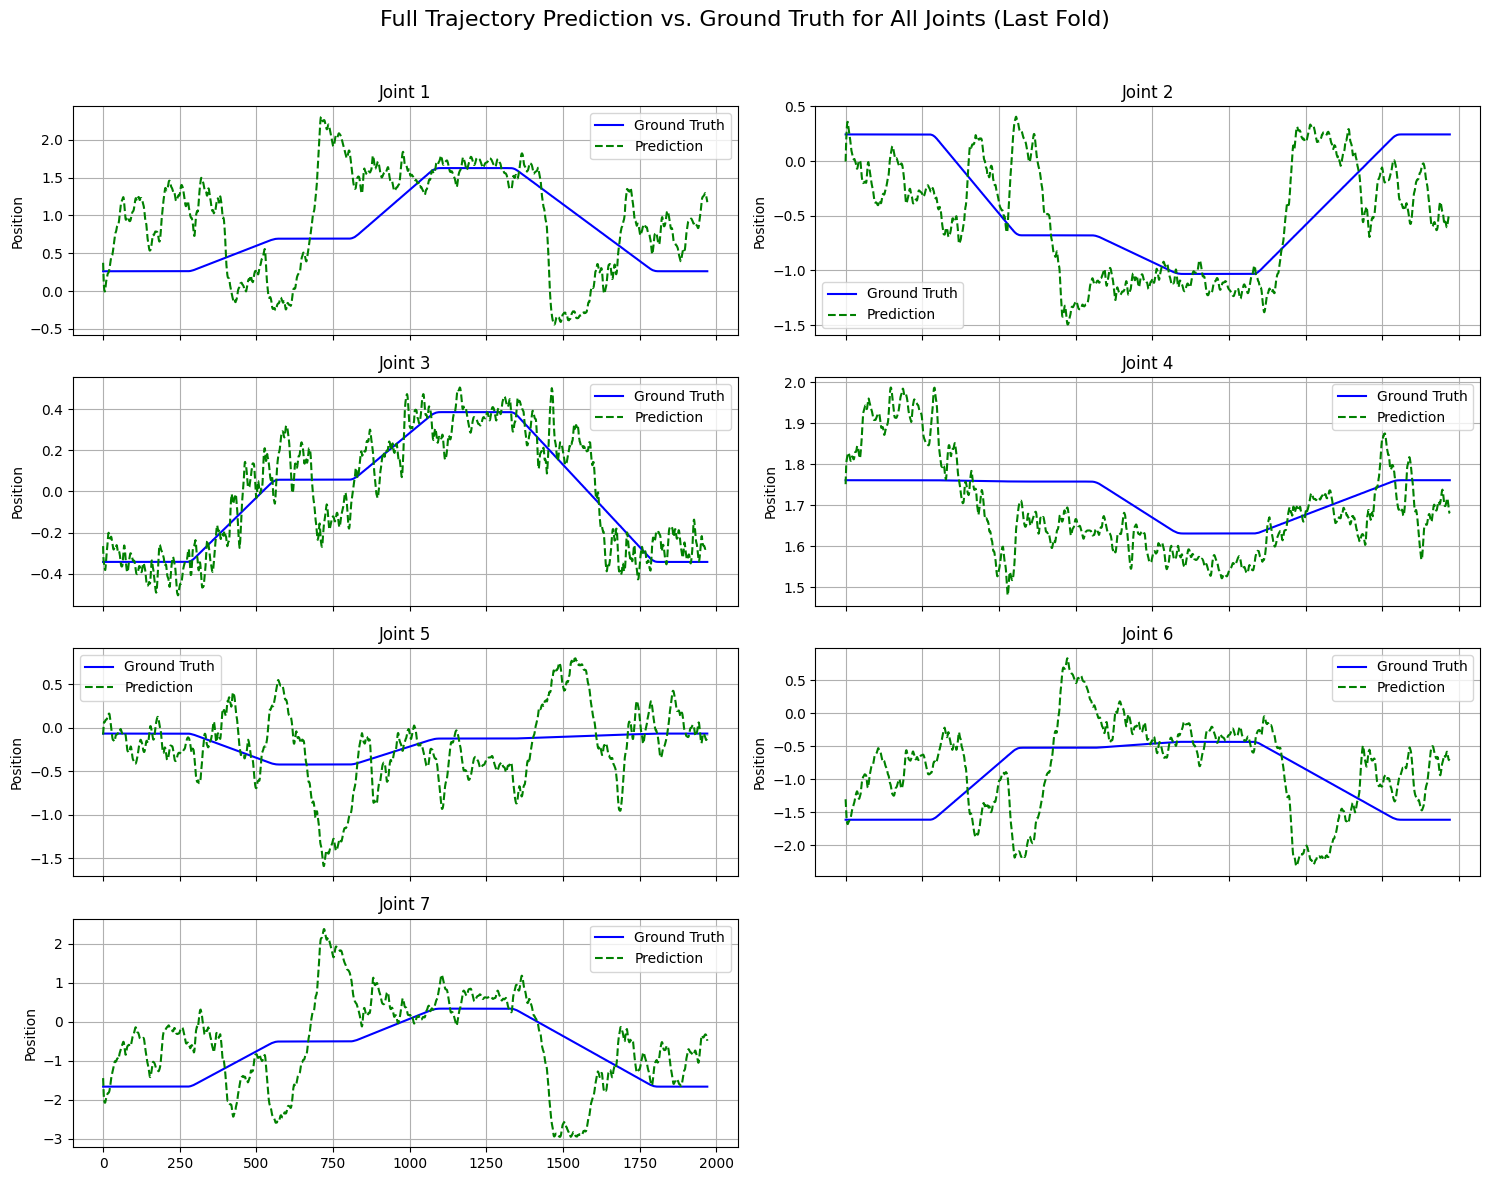

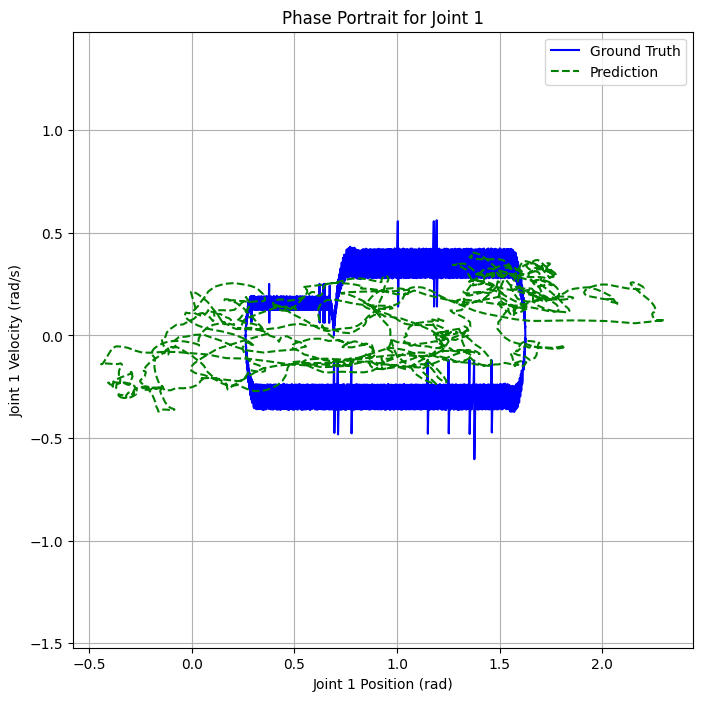

In [31]:
# --- Plot 1: Convergence Plot (Replicating Paper's Fig. 5) ---
fig1, ax1 = plt.subplots(figsize=(10, 6))
num_trajectories = np.arange(1, len(results_df) + 1)
ax1.plot(results_df['sbs_pos_nmse'].expanding().mean(), 'r-o', label='Step-by-Step nMSE')
ax1.plot(results_df['full_pos_nmse'].expanding().mean(), 'b-s', label='Full Trajectory nMSE')
ax1.set_yscale('log'); ax1.set_xlabel('Number of Trained Trajectories'); ax1.set_ylabel('nMSE (Position, log scale)')
ax1.set_title('Model Convergence vs. Training Data (Averaged Over Folds)'); ax1.legend(); ax1.grid(True, which="both", ls="--")

# --- Plot 2: Operational Space Error vs. Horizon (Replicating Paper's Fig. 6) ---
fig2, ax2 = plt.subplots(figsize=(10, 6))
horizon_cols = [f'full_euclid_err_h{h}' for h in horizons if f'full_euclid_err_h{h}' in results_df.columns]

mean_op_errors = results_df[horizon_cols].mean()
ax2.plot(horizons, mean_op_errors.values, 'm-o', label='PC-ESN++')
ax2.set_xlabel('Prediction Horizon'); ax2.set_ylabel('Operational Space Euclidean Error (m)')
ax2.set_title('End-Effector Error vs. Prediction Horizon (Averaged Over Folds)'); ax2.legend(); ax2.grid(True)

# --- Plot 3: All Joints Full Trajectory Prediction ---
fig3, axs3 = plt.subplots(4, 2, figsize=(15, 12), sharex=True)
fig3.suptitle('Full Trajectory Prediction vs. Ground Truth for All Joints (Last Fold)', fontsize=16)
axs3 = axs3.ravel()
for i in range(8):
    axs3[i].plot(last_fold_preds['true'][:, i], 'b-', label='Ground Truth')
    axs3[i].plot(last_fold_preds['full'][:, i], 'g--', label='Prediction')
    axs3[i].set_title(f'Joint {i+1}'); axs3[i].set_ylabel('Position'); axs3[i].grid(True); axs3[i].legend()
axs3[-1].set_visible(False)
plt.tight_layout(rect=[0, 0, 1, 0.96]);

# --- Plot 4: Phase Portrait for a Sample Joint (SAFEGUARD ADDED) ---
fig4, ax4 = plt.subplots(figsize=(8, 8))
joint_to_plot = 0

ax4.plot(last_fold_preds['true'][:, joint_to_plot], last_fold_preds['true'][:, joint_to_plot + 7], 'b-', label='Ground Truth')
ax4.plot(last_fold_preds['full'][:, joint_to_plot], last_fold_preds['full'][:, joint_to_plot + 7], 'g--', label='Prediction')
ax4.set_xlabel(f'Joint {joint_to_plot+1} Position (rad)'); ax4.set_ylabel(f'Joint {joint_to_plot+1} Velocity (rad/s)')
ax4.set_title(f'Phase Portrait for Joint {joint_to_plot+1}'); ax4.legend(); ax4.grid(True); ax4.axis('equal')